In [1]:
import pandas as pd 
import datetime 
import pandas_datareader as pdr 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM,GRU,SimpleRNN,Dropout,Conv1D,MaxPooling1D,Dense
from keras.optimizers import RMSprop,SGD,Adagrad
from keras import metrics
from sklearn.metrics import mean_squared_error

start = datetime.datetime(2014, 9, 20) 
end = datetime.datetime(2021, 5, 20)
df = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end) 
df.reset_index(level=0, inplace=True)
df.tail()

Attributes,Date,Adj Close,Close,High,Low,Open,Volume
Symbols,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
2427,2021-05-16,43537.511719,43537.511719,46623.558594,42207.289062,46415.898438,7.490364e+10
2428,2021-05-17,42909.402344,42909.402344,45812.457031,42367.832031,43488.058594,5.618737e+10
2429,2021-05-18,37002.441406,37002.441406,43546.117188,30681.496094,42944.976562,1.263581e+11
2430,2021-05-19,40782.738281,40782.738281,42462.984375,35050.617188,36753.667969,8.828194e+10
2431,2021-05-20,37304.691406,37304.691406,42172.171875,33616.453125,40596.949219,8.205162e+10


X_train: (2275, 28, 1)
y_train: (2275,)
X_test: (100, 28, 1)
y_test: (100, 1)


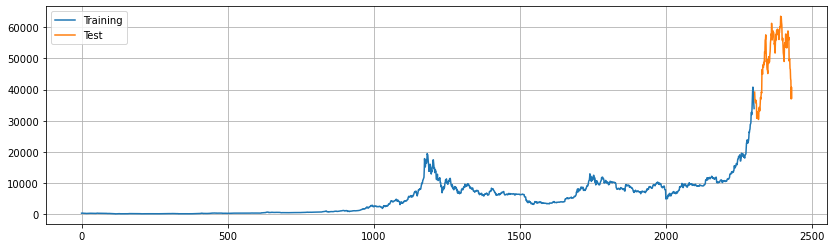

In [2]:
prediction_days = 28
scaler = MinMaxScaler()
standard_scaler = StandardScaler()
power_scaler = PowerTransformer()

X_train = []
y_train = []

X_train_standard = []
y_train_standard = []

X_train_power = []
y_train_power = []

data_training = df[df['Date']< '2021-01-13'].copy().Close
training_data = scaler.fit_transform(data_training)
training_data_standard = standard_scaler.fit_transform(data_training)
training_data_power = power_scaler.fit_transform(data_training)

for i in range(prediction_days,training_data.shape[0]):
    X_train.append(training_data[i-prediction_days:i])
    y_train.append(training_data[i, 0])

    X_train_standard.append(training_data_standard[i-prediction_days:i])
    y_train_standard.append(training_data_standard[i, 0])
    
    X_train_power.append(training_data_power[i-prediction_days:i])
    y_train_power.append(training_data_power[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train_standard, y_train_standard = np.array(X_train_standard), np.array(y_train_standard)
X_train_power, y_train_power = np.array(X_train_power), np.array(y_train_power)

print("X_train:",X_train.shape)
print("y_train:",y_train.shape)

X_test  = []
X_test_standard  = []
X_test_power  = []

data_test = df[df['Date']> '2021-01-13'].copy().Close
testing_data = scaler.transform(data_test)
testing_data_standard = standard_scaler.transform(data_test)
testing_data_power = power_scaler.transform(data_test)

for i in range(prediction_days,testing_data.shape[0]):
    X_test.append(testing_data[i-prediction_days:i])
    X_test_standard.append(testing_data_standard[i-prediction_days:i])
    X_test_power.append(testing_data_power[i-prediction_days:i])

X_test = np.array(X_test)
X_test_standard = np.array(X_test_standard)
X_test_power = np.array(X_test_power)

y_test = data_test.copy()[28:]
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

plt.figure(figsize=(14,4))
plt.plot(data_training)
plt.plot(data_test)
plt.legend(["Training", "Test"])
plt.grid()

In [3]:
def plot_prediction(y_pred):
    plt.plot(range(y_test.shape[0]),y_test, color = 'red', label = "Real Price")
    plt.plot(range(y_pred.shape[0]),y_pred, color = 'green', label = "Predicted Price")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price")
    plt.legend()
    plt.show()
def plot_history(epochs,history):
    plt.figure()
    plt.plot(range(epochs), history.history['loss'], 'b', label='Training loss')
    plt.plot(range(epochs), history.history['val_loss'], 'r', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
def results_dataframe(histories):
    results = []
    for hist in histories:
        results.append({
            "model": hist[0],
            "epochs":200,
            "dropout":0.2,
            "MSE": hist[1].history["mean_squared_error"][-1],
            "min_MSE":np.array(hist[1].history["mean_squared_error"]).min(),
            "min_MSE_index":np.array(hist[1].history["mean_squared_error"]).argmin(),
            "MAE": hist[1].history["mean_absolute_error"][-1],
            "loss": hist[1].history["loss"][-1],
            "val_loss": hist[1].history["val_loss"][-1],
            "val_MSE": hist[1].history["val_mean_squared_error"][-1],
            "min_val_MSE":np.array(hist[1].history["val_mean_squared_error"]).min(),
            "min_val_MSE_index":np.array(hist[1].history["val_mean_squared_error"]).argmin(),
            "val_MAE": hist[1].history["val_mean_absolute_error"][-1],
            "train_time":hist[2]
        })
    return pd.DataFrame(results)

# 2

In [4]:
epochs=200

Epoch 1/200
16/16 [==============================] - 1s 68ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0458 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0564
Epoch 2/200
16/16 [==============================] - 1s 34ms/step - loss: 5.1163e-04 - mean_squared_error: 5.1163e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0171
Epoch 3/200
16/16 [==============================] - 1s 34ms/step - loss: 3.3479e-04 - mean_squared_error: 3.3479e-04 - mean_absolute_error: 0.0118 - val_loss: 9.6676e-04 - val_mean_squared_error: 9.6676e-04 - val_mean_absolute_error: 0.0163
Epoch 4/200
16/16 [==============================] - 1s 35ms/step - loss: 2.7706e-04 - mean_squared_error: 2.7706e-04 - mean_absolute_error: 0.0101 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0191
Epoch 5/200
16/16 [==============================] - 1s 38ms/ste

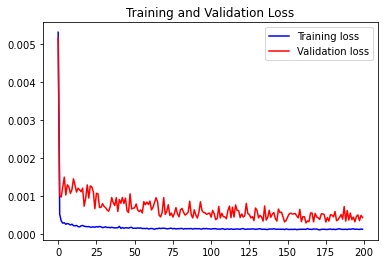

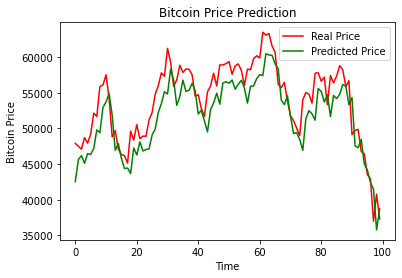

Wall time: 2min 16s


In [5]:
%%time
model_RNN=Sequential()
model_RNN.add(SimpleRNN(200,input_shape=(None,1),activation="relu"))
model_RNN.add(Dropout(0.2)) 
model_RNN.add(Dense(1))
model_RNN.compile(loss="mean_squared_error",optimizer="adam",metrics =[metrics.mse,metrics.mae])
history_RNN = model_RNN.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_RNN)
y_pred_RNN = scaler.inverse_transform(model_RNN.predict(X_test))
plot_prediction(y_pred_RNN)
pd.DataFrame(history_RNN.history).to_csv("model/model_RNN/history.csv")
model_RNN.save("model/model_RNN")

In [15]:
mean_squared_error(y_test, y_pred_RNN)

10049154.0262677

Epoch 1/200
16/16 [==============================] - 2s 148ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0483 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0347
Epoch 2/200
16/16 [==============================] - 2s 102ms/step - loss: 6.1447e-04 - mean_squared_error: 6.1447e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0329
Epoch 3/200
16/16 [==============================] - 2s 113ms/step - loss: 3.9504e-04 - mean_squared_error: 3.9504e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0212
Epoch 4/200
16/16 [==============================] - 2s 110ms/step - loss: 3.5991e-04 - mean_squared_error: 3.5991e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0261
Epoch 5/200
16/16 [==============================] - 2s 101ms/step -

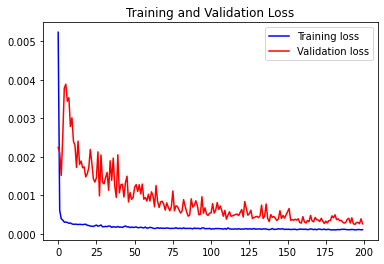

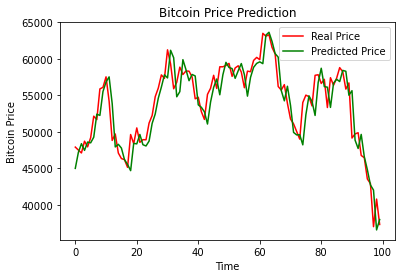

Wall time: 5min 37s


In [14]:
%%time
model_LSTM=Sequential()
model_LSTM.add(LSTM(200,input_shape=(None,1),activation="relu"))
model_LSTM.add(Dropout(0.2)) 
model_LSTM.add(Dense(1))
model_LSTM.compile(loss="mean_squared_error",optimizer="adam",metrics =[metrics.mse,metrics.mae])
history_LSTM = model_LSTM.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_LSTM)
y_pred_LSTM = scaler.inverse_transform(model_LSTM.predict(X_test))
plot_prediction(y_pred_LSTM)
pd.DataFrame(history_LSTM.history).to_csv("model/model_LSTM/history.csv")
model_LSTM.save("model/model_LSTM")

In [16]:
mean_squared_error(y_test, y_pred_LSTM)

5280789.923812256

Epoch 1/200
16/16 [==============================] - 2s 133ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0560 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1025
Epoch 2/200
16/16 [==============================] - 2s 103ms/step - loss: 7.5422e-04 - mean_squared_error: 7.5422e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0159
Epoch 3/200
16/16 [==============================] - 1s 86ms/step - loss: 3.0689e-04 - mean_squared_error: 3.0689e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0258
Epoch 4/200
16/16 [==============================] - 1s 83ms/step - loss: 2.6947e-04 - mean_squared_error: 2.6947e-04 - mean_absolute_error: 0.0112 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0247
Epoch 5/200
16/16 [==============================] - 1s 86ms/step - lo

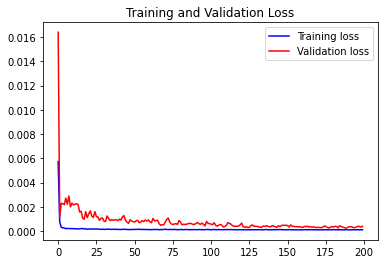

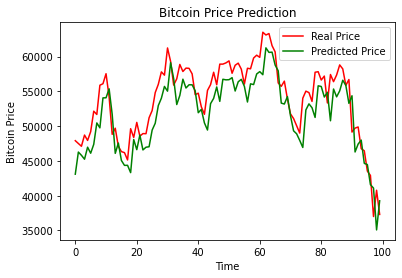

Wall time: 4min 56s


In [7]:
%%time
model_GRU=Sequential()
model_GRU.add(GRU(200,input_shape=(None,1),activation="relu"))
model_GRU.add(Dropout(0.2)) 
model_GRU.add(Dense(1))
model_GRU.compile(loss="mean_squared_error",optimizer="adam",metrics =[metrics.mse,metrics.mae])
history_GRU = model_GRU.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_GRU)
y_pred_GRU = scaler.inverse_transform(model_GRU.predict(X_test))
plot_prediction(y_pred_GRU)
pd.DataFrame(history_GRU.history).to_csv("model/model_GRU/history.csv")
model_GRU.save("model/model_GRU")

In [17]:
mean_squared_error(y_test, y_pred_GRU)

9571154.506332245

In [24]:
results_dataframe([("RNN",history_RNN,136),("LSTM",history_LSTM,337),("GRU",history_GRU,296)])

,model,epochs,dropout,MSE,min_MSE,min_MSE_index,MAE,loss,val_loss,val_MSE,min_val_MSE,min_val_MSE_index,val_MAE,train_time
0,RNN,200,0.2,0.000115,0.000099,171,0.007107,0.000115,0.000425,0.000425,0.000283,162,0.012295,136
1,LSTM,200,0.2,0.000112,0.000105,179,0.007046,0.000112,0.000265,0.000265,0.000247,194,0.009594,337
2,GRU,200,0.2,0.000103,0.000092,187,0.006535,0.000103,0.000391,0.000391,0.000232,188,0.012522,296


# 3- Loss Function

Epoch 1/200
16/16 [==============================] - 3s 189ms/step - loss: 0.0597 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0597 - val_loss: 0.0934 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0934
Epoch 2/200
16/16 [==============================] - 2s 130ms/step - loss: 0.0193 - mean_squared_error: 9.0954e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0270 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0270
Epoch 3/200
16/16 [==============================] - 2s 133ms/step - loss: 0.0125 - mean_squared_error: 4.5517e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0419 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0419
Epoch 4/200
16/16 [==============================] - 2s 138ms/step - loss: 0.0116 - mean_squared_error: 4.4993e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0525 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0525
Epoch 5/200
16/16 [==============================] - 2s 125ms/step - loss: 0.011

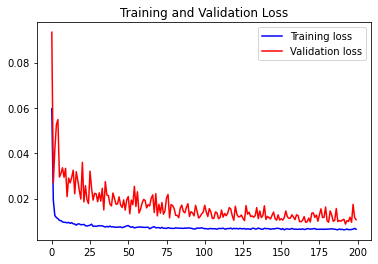

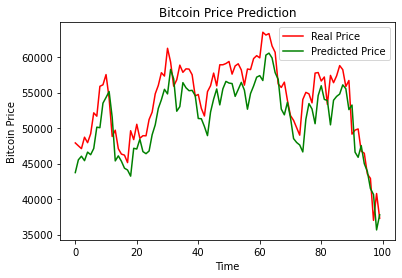

Wall time: 6min 37s


In [10]:
%%time
model_MAE=Sequential()
model_MAE.add(LSTM(200,input_shape=(None,1),activation="relu"))
model_MAE.add(Dropout(0.2)) 
model_MAE.add(Dense(1))
model_MAE.compile(loss="mean_absolute_error",optimizer="adam",metrics =[metrics.mse,metrics.mae])
history_MAE = model_MAE.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_MAE)
y_pred_MAE = scaler.inverse_transform(model_MAE.predict(X_test))
plot_prediction(y_pred_MAE)
pd.DataFrame(history_MAE.history).to_csv("model/model_MAE/history.csv")
model_MAE.save("model/model_MAE")

In [18]:
mean_squared_error(y_test, y_pred_MAE)

11191250.659677735

In [25]:
results_dataframe([("MSE",history_LSTM,337),("MAE",history_MAE,397)])

,model,epochs,dropout,MSE,min_MSE,min_MSE_index,MAE,loss,val_loss,val_MSE,min_val_MSE,min_val_MSE_index,val_MAE,train_time
0,MSE,200,0.2,0.000112,0.000105,179,0.007046,0.000112,0.000265,0.000265,0.000247,194,0.009594,337
1,MAE,200,0.2,0.000148,0.000122,195,0.006468,0.006468,0.010682,0.000359,0.000234,192,0.010682,397


# 3- Optimizer

Epoch 1/200
16/16 [==============================] - 2s 143ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0875 - val_loss: 0.1247 - val_mean_squared_error: 0.1247 - val_mean_absolute_error: 0.3158
Epoch 2/200
16/16 [==============================] - 2s 103ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0826 - val_loss: 0.1180 - val_mean_squared_error: 0.1180 - val_mean_absolute_error: 0.3053
Epoch 3/200
16/16 [==============================] - 2s 115ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0800 - val_loss: 0.1127 - val_mean_squared_error: 0.1127 - val_mean_absolute_error: 0.2966
Epoch 4/200
16/16 [==============================] - 2s 127ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0783 - val_loss: 0.1082 - val_mean_squared_error: 0.1082 - val_mean_absolute_error: 0.2891
Epoch 5/200
16/16 [==============================] - 2s 126ms/step - loss: 0.0110 - mean_squ

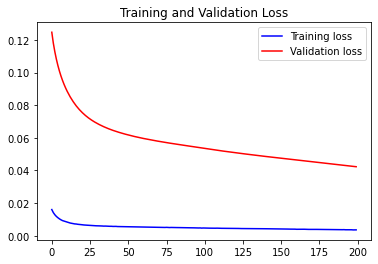

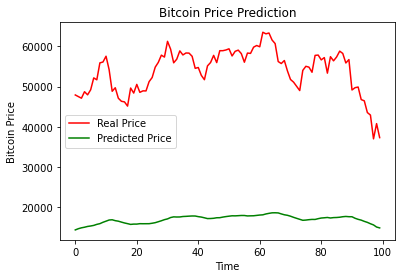

Wall time: 5min 49s


In [18]:
%%time
model_Adagrad=Sequential()
model_Adagrad.add(LSTM(200,input_shape=(None,1),activation="relu"))
model_Adagrad.add(Dropout(0.2)) 
model_Adagrad.add(Dense(1))
model_Adagrad.compile(loss="mean_squared_error",optimizer="Adagrad",metrics =[metrics.mse,metrics.mae])
history_Adagrad = model_Adagrad.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_Adagrad)
y_pred_Adagrad = scaler.inverse_transform(model_Adagrad.predict(X_test))
plot_prediction(y_pred_Adagrad)
pd.DataFrame(history_Adagrad.history).to_csv("model/model_Adagrad/history.csv")
model_Adagrad.save("model/model_Adagrad")

In [19]:
mean_squared_error(y_test, y_pred_Adagrad)

1385078919.1672375

Epoch 1/200
16/16 [==============================] - 2s 131ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0852 - val_loss: 0.1123 - val_mean_squared_error: 0.1123 - val_mean_absolute_error: 0.2936
Epoch 2/200
16/16 [==============================] - 2s 110ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0777 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - val_mean_absolute_error: 0.2664
Epoch 3/200
16/16 [==============================] - 2s 106ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0744 - val_loss: 0.0876 - val_mean_squared_error: 0.0876 - val_mean_absolute_error: 0.2491
Epoch 4/200
16/16 [==============================] - 2s 102ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0724 - val_loss: 0.0819 - val_mean_squared_error: 0.0819 - val_mean_absolute_error: 0.2378
Epoch 5/200
16/16 [==============================] - 2s 99ms/step - loss: 0.0071 - mean_squa

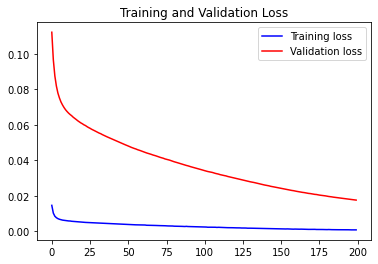

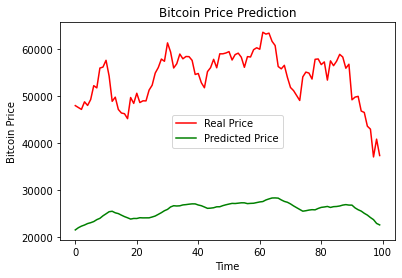

Wall time: 5min 42s


In [19]:
%%time
model_SGD=Sequential()
model_SGD.add(LSTM(200,input_shape=(None,1),activation="relu"))
model_SGD.add(Dropout(0.2)) 
model_SGD.add(Dense(1))
model_SGD.compile(loss="mean_squared_error",optimizer="SGD",metrics =[metrics.mse,metrics.mae])
history_SGD = model_SGD.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_SGD)
y_pred_SGD = scaler.inverse_transform(model_SGD.predict(X_test))
plot_prediction(y_pred_SGD)
pd.DataFrame(history_SGD.history).to_csv("model/model_SGD/history.csv")
model_SGD.save("model/model_SGD")

In [20]:
mean_squared_error(y_test, y_pred_SGD)

812233740.9719297

Epoch 1/200
16/16 [==============================] - 2s 137ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0398 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0343
Epoch 2/200
16/16 [==============================] - 2s 107ms/step - loss: 7.6411e-04 - mean_squared_error: 7.6411e-04 - mean_absolute_error: 0.0176 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0440
Epoch 3/200
16/16 [==============================] - 2s 109ms/step - loss: 6.5351e-04 - mean_squared_error: 6.5351e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0452
Epoch 4/200
16/16 [==============================] - 2s 106ms/step - loss: 7.8955e-04 - mean_squared_error: 7.8955e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1220
Epoch 5/200
16/16 [==============================] - 2s 108ms/step -

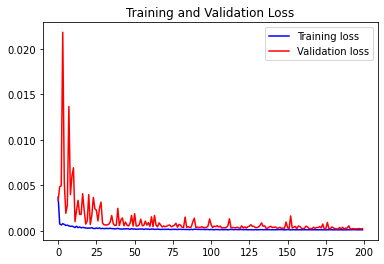

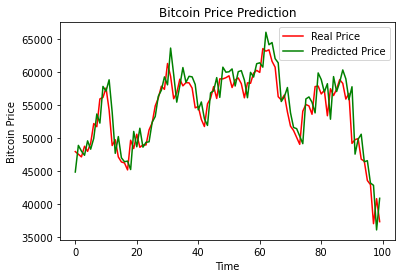

Wall time: 5min 45s


In [20]:
%%time
model_RMS=Sequential()
model_RMS.add(LSTM(200,input_shape=(None,1),activation="relu"))
model_RMS.add(Dropout(0.2)) 
model_RMS.add(Dense(1))
model_RMS.compile(loss="mean_squared_error",optimizer="RMSprop",metrics =[metrics.mse,metrics.mae])
history_RMS = model_RMS.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_RMS)
y_pred_RMS = scaler.inverse_transform(model_RMS.predict(X_test))
plot_prediction(y_pred_RMS)
pd.DataFrame(history_RMS.history).to_csv("model/model_RMS/history.csv")
model_RMS.save("model/model_RMS")

In [21]:
mean_squared_error(y_test, y_pred_RMS)

6638915.192040711

In [30]:
results_dataframe([("Adam",history_LSTM,337),("Adagrad",history_Adagrad,349),("SGD",history_SGD,342),("RMS",history_RMS,345)])

,model,epochs,dropout,MSE,min_MSE,min_MSE_index,MAE,loss,val_loss,val_MSE,min_val_MSE,min_val_MSE_index,val_MAE,train_time
0,Adam,200,0.2,0.000112,0.000105,179,0.007046,0.000112,0.000265,0.000265,0.000247,194,0.009594,337
1,Adagrad,200,0.2,0.003610,0.003582,197,0.051723,0.003610,0.042316,0.042316,0.042316,199,0.162182,349
2,SGD,200,0.2,0.000726,0.000703,198,0.020277,0.000726,0.017531,0.017531,0.017531,199,0.084914,342
3,RMS,200,0.2,0.000122,0.000109,159,0.007215,0.000122,0.000246,0.000246,0.000215,198,0.009701,345


# 4 Dropout in cell

Epoch 1/200
16/16 [==============================] - 1s 64ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0345 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0281
Epoch 2/200
16/16 [==============================] - 1s 38ms/step - loss: 7.5185e-04 - mean_squared_error: 7.5185e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0502
Epoch 3/200
16/16 [==============================] - 1s 38ms/step - loss: 9.0133e-04 - mean_squared_error: 9.0133e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0514
Epoch 4/200
16/16 [==============================] - 1s 39ms/step - loss: 5.7373e-04 - mean_squared_error: 5.7373e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0623
Epoch 5/200
16/16 [==============================] - 1s 37ms/step - loss

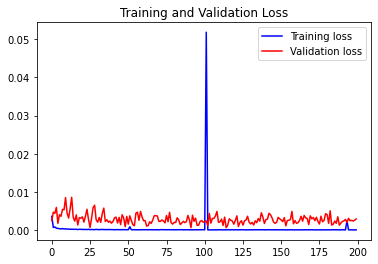

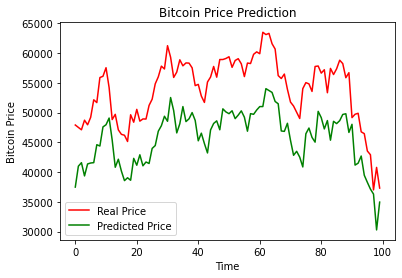

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/model_RNN_Dropout\assets
Wall time: 2min 16s


In [11]:
%%time
model_RNN_Dropout=Sequential()
model_RNN_Dropout.add(SimpleRNN(200,input_shape=(None,1),activation="relu",dropout=0.1))
model_RNN_Dropout.add(Dropout(0.2)) 
model_RNN_Dropout.add(Dense(1))
model_RNN_Dropout.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_RNN_Dropout = model_RNN_Dropout.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_RNN_Dropout)
y_pred_RNN_Dropout = scaler.inverse_transform(model_RNN_Dropout.predict(X_test))
plot_prediction(y_pred_RNN_Dropout)
model_RNN_Dropout.save("model/model_RNN_Dropout")
pd.DataFrame(history_RNN_Dropout.history).to_csv("model/model_RNN_Dropout/history.csv")

In [22]:
mean_squared_error(y_test, y_pred_RNN_Dropout)

71988644.33249012

Epoch 1/200
16/16 [==============================] - 2s 128ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0449 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1068
Epoch 2/200
16/16 [==============================] - 2s 100ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0218 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0324
Epoch 3/200
16/16 [==============================] - 2s 101ms/step - loss: 7.6067e-04 - mean_squared_error: 7.6067e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0298
Epoch 4/200
16/16 [==============================] - 2s 105ms/step - loss: 7.0856e-04 - mean_squared_error: 7.0856e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0763
Epoch 5/200
16/16 [==============================] - 2s 105ms/step - loss: 8

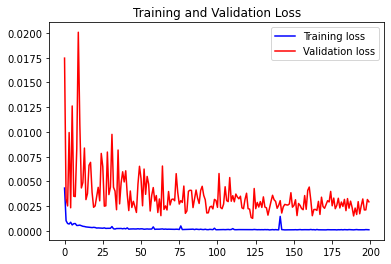

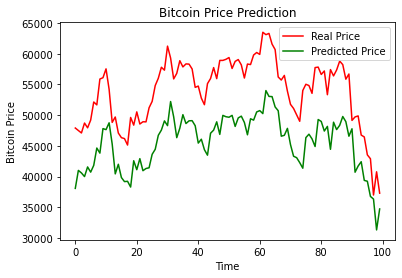

INFO:tensorflow:Assets written to: model/model_LSTM_Dropout\assets
Wall time: 6min 20s


In [12]:
%%time
model_LSTM_Dropout=Sequential()
model_LSTM_Dropout.add(LSTM(200,input_shape=(None,1),activation="relu",dropout=0.1))
model_LSTM_Dropout.add(Dropout(0.2)) 
model_LSTM_Dropout.add(Dense(1))
model_LSTM_Dropout.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_LSTM_Dropout = model_LSTM_Dropout.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_LSTM_Dropout)
y_pred_LSTM_Dropout = scaler.inverse_transform(model_LSTM_Dropout.predict(X_test))
plot_prediction(y_pred_LSTM_Dropout)
model_LSTM_Dropout.save("model/model_LSTM_Dropout")
pd.DataFrame(history_LSTM_Dropout.history).to_csv("model/model_LSTM_Dropout/history.csv")

In [23]:
mean_squared_error(y_test, y_pred_LSTM_Dropout)

74964193.96401417

Epoch 1/200
16/16 [==============================] - 2s 139ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0440 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0667
Epoch 2/200
16/16 [==============================] - 2s 117ms/step - loss: 7.8796e-04 - mean_squared_error: 7.8796e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0281
Epoch 3/200
16/16 [==============================] - 2s 96ms/step - loss: 6.6949e-04 - mean_squared_error: 6.6949e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0281
Epoch 4/200
16/16 [==============================] - 2s 105ms/step - loss: 6.3336e-04 - mean_squared_error: 6.3336e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0317
Epoch 5/200
16/16 [==============================] - 2s 104ms/step - 

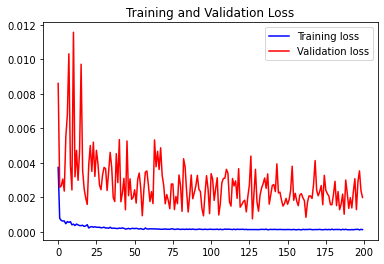

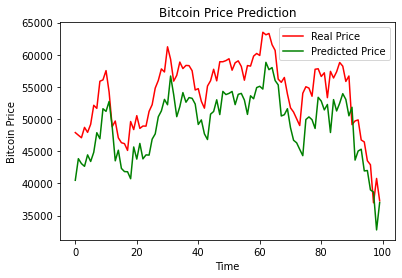

INFO:tensorflow:Assets written to: model/model_GRU_Dropout\assets
Wall time: 5min 46s


In [13]:
%%time
model_GRU_Dropout=Sequential()
model_GRU_Dropout.add(GRU(200,input_shape=(None,1),activation="relu",dropout=0.1))
model_GRU_Dropout.add(Dropout(0.2)) 
model_GRU_Dropout.add(Dense(1))
model_GRU_Dropout.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_GRU_Dropout = model_GRU_Dropout.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_GRU_Dropout)
y_pred_GRU_Dropout = scaler.inverse_transform(model_GRU_Dropout.predict(X_test))
plot_prediction(y_pred_GRU_Dropout)
model_GRU_Dropout.save("model/model_GRU_Dropout")
pd.DataFrame(history_GRU_Dropout.history).to_csv("model/model_GRU_Dropout/history.csv")

In [24]:
mean_squared_error(y_test, y_pred_GRU_Dropout)

27815041.430805054

In [15]:
results_dataframe([("RNN",history_RNN_Dropout,137),("LSTM",history_LSTM_Dropout,380),("GRU",history_GRU_Dropout,542)])

,model,epochs,dropout,MSE,min_MSE,min_MSE_index,MAE,loss,val_loss,val_MSE,min_val_MSE,min_val_MSE_index,val_MAE,train_time
0,RNN,200,0.2,0.000151,0.000121,198,0.007976,0.000151,0.002990,0.002990,0.000706,91,0.045866,137
1,LSTM,200,0.2,0.000130,0.000112,134,0.007369,0.000130,0.002948,0.002948,0.001282,123,0.045425,380
2,GRU,200,0.2,0.000137,0.000120,197,0.007557,0.000137,0.002000,0.002000,0.000762,127,0.038340,542


# 5 MLP

Epoch 1/200
16/16 [==============================] - 0s 25ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0519 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1375
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0351 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0977
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0313 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0773
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0285 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0618
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_erro

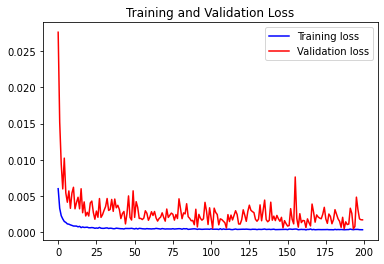

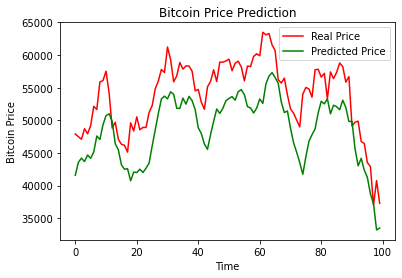

Wall time: 26.9 s


In [32]:
%%time
model_MLP = Sequential()
model_MLP.add(Dense(200, input_dim=28, activation='relu'))
model_MLP.add(Dropout(0.2)) 
model_MLP.add(Dense(100, activation='relu'))
model_MLP.add(Dropout(0.2)) 
model_MLP.add(Dense(50,  activation='relu'))
model_MLP.add(Dropout(0.2)) 
model_MLP.add(Dense(25,  activation='relu'))
model_MLP.add(Dropout(0.2)) 
model_MLP.add(Dense(1))
model_MLP.compile(optimizer ='Adam', loss = 'Adam',metrics =[metrics.mse,metrics.mae])
history_MLP = model_MLP.fit(X_train.reshape(2275,28), y_train, validation_split=0.1, epochs=epochs, batch_size=128)

plot_history(epochs,history_MLP)
y_pred_MLP = scaler.inverse_transform(model_MLP.predict(X_test.reshape(100,28)))
plot_prediction(y_pred_MLP)
pd.DataFrame(history_MLP.history).to_csv("model/model_MLP/history.csv")
model_MLP.save("model/model_MLP")

In [29]:
mean_squared_error(y_test, y_pred_MLP)

33670192.619823

# 6 Multi features

In [34]:
prediction_days = 28
scaler_5 = MinMaxScaler()

X_train_5 = []
y_train_5 = []
data_training_5 = df[df['Date']< '2021-01-13'].copy()[["Close","High","Low","Open","Volume"]]
training_data_5 = scaler_5.fit_transform(data_training_5)
for i in range(prediction_days,training_data_5.shape[0]):
    X_train_5.append(training_data_5[i-prediction_days:i])
    y_train_5.append(training_data_5[i, 0])
X_train_5, y_train_5 = np.array(X_train_5), np.array(y_train_5)
print("X_train:",X_train_5.shape)
print("y_train:",y_train_5.shape)

data_test_5 = df[df['Date']> '2021-01-13'].copy()[["Close","High","Low","Open","Volume"]]
testing_data_5 = scaler_5.transform(data_test_5)
X_test_5  = []
for i in range(prediction_days,testing_data_5.shape[0]):
    X_test_5.append(testing_data_5[i-prediction_days:i])
X_test_5 = np.array(X_test_5)
y_test_5 = data_test.copy()[28:]
print("X_test:",X_test_5.shape)
print("y_test:",y_test_5.shape)

X_train: (2275, 28, 5)
y_train: (2275,)
X_test: (100, 28, 5)
y_test: (100, 1)


Epoch 1/200
16/16 [==============================] - 3s 165ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0397 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0764
Epoch 2/200
16/16 [==============================] - 2s 132ms/step - loss: 6.5891e-04 - mean_squared_error: 6.5891e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0296
Epoch 3/200
16/16 [==============================] - 2s 139ms/step - loss: 3.9099e-04 - mean_squared_error: 3.9099e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0272
Epoch 4/200
16/16 [==============================] - 2s 129ms/step - loss: 3.4102e-04 - mean_squared_error: 3.4102e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0207
Epoch 5/200
16/16 [==============================] - 2s 121ms/step -

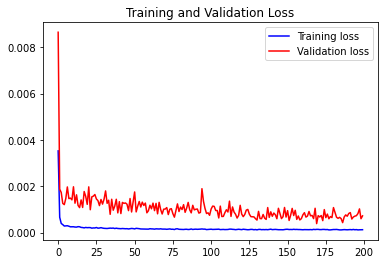

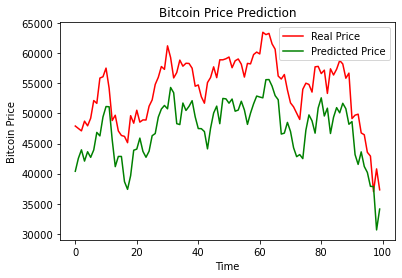

Wall time: 7min 3s


In [117]:
%%time
model_Multi_Feature=Sequential()
model_Multi_Feature.add(LSTM(200,input_shape=(None,5),activation="relu"))
model_Multi_Feature.add(Dropout(0.2)) 
model_Multi_Feature.add(Dense(1))
model_Multi_Feature.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_Multi_Feature = model_Multi_Feature.fit(X_train_5,y_train_5,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_Multi_Feature)
y_pred_Multi_Feature = scaler.inverse_transform(model_Multi_Feature.predict(X_test_5))
plot_prediction(y_pred_Multi_Feature)
pd.DataFrame(history_Multi_Feature.history).to_csv("model/model_Multi_Feature/history.csv")
model_Multi_Feature.save("model/model_Multi_Feature")

In [36]:
mean_squared_error(y_test, y_pred_Multi_Feature)

258779059.02688518

In [118]:
results_dataframe([("Single_Feature",model_LSTM,337),("Multi_Feature",history_Multi_Feature,423)])

,model,epochs,dropout,MSE,min_MSE,min_MSE_index,MAE,loss,val_loss,val_MSE,min_val_MSE,min_val_MSE_index,val_MAE,train_time
0,Single_Feature,200,0.2,0.000122,0.000109,159,0.007215,0.000122,0.000246,0.000246,0.000215,198,0.009701,337
1,Multi_Feature,200,0.2,0.000121,0.000112,196,0.007112,0.000121,0.000719,0.000719,0.000385,169,0.014803,423


# 7 Multi Layer

Epoch 1/200
16/16 [==============================] - 4s 277ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0406 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0363
Epoch 2/200
16/16 [==============================] - 3s 187ms/step - loss: 8.1626e-04 - mean_squared_error: 8.1626e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0342
Epoch 3/200
16/16 [==============================] - 4s 222ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0214 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0713
Epoch 4/200
16/16 [==============================] - 4s 226ms/step - loss: 9.1475e-04 - mean_squared_error: 9.1475e-04 - mean_absolute_error: 0.0196 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0663
Epoch 5/200
16/16 [==============================] - 3s 207ms/step - loss: 8

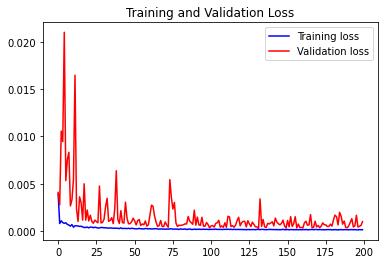

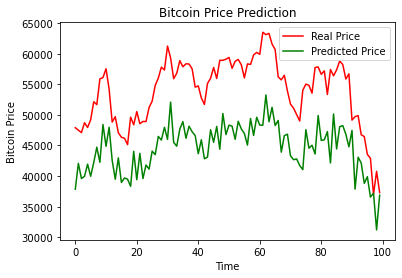

Wall time: 12min 31s


In [36]:
%%time
model_Multi_Layer=Sequential()
model_Multi_Layer.add(LSTM(200,input_shape=(None,1),activation="relu",return_sequences=True))
model_Multi_Layer.add(Dropout(0.2)) 
model_Multi_Layer.add(LSTM(100,activation="relu"))
model_Multi_Layer.add(Dropout(0.2)) 
model_Multi_Layer.add(Dense(1))
model_Multi_Layer.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_Multi_Layer = model_Multi_Layer.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_Multi_Layer)
y_pred_Multi_Layer = scaler.inverse_transform(model_Multi_Layer.predict(X_test))
plot_prediction(y_pred_Multi_Layer)
pd.DataFrame(history_Multi_Layer.history).to_csv("model/model_Multi_Layer/history.csv")
model_Multi_Layer.save("model/model_Multi_Layer")

In [37]:
mean_squared_error(y_test, y_pred_Multi_Layer)

95449757.69912067

Epoch 1/200
16/16 [==============================] - 4s 226ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0396 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0373
Epoch 2/200
16/16 [==============================] - 3s 177ms/step - loss: 8.5978e-04 - mean_squared_error: 8.5978e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0385
Epoch 3/200
16/16 [==============================] - 3s 177ms/step - loss: 7.8129e-04 - mean_squared_error: 7.8129e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0330
Epoch 4/200
16/16 [==============================] - 3s 175ms/step - loss: 5.9981e-04 - mean_squared_error: 5.9981e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0364
Epoch 5/200
16/16 [==============================] - 3s 177ms/step -

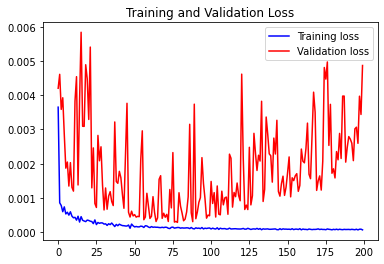

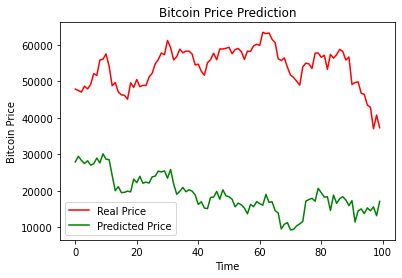

Wall time: 10min 25s


In [37]:
%%time
model_Multi_Layer_Without_DropOut=Sequential()
model_Multi_Layer_Without_DropOut.add(LSTM(200,input_shape=(None,1),activation="relu",return_sequences=True))
model_Multi_Layer_Without_DropOut.add(LSTM(100,activation="relu"))
model_Multi_Layer_Without_DropOut.add(Dense(1))
model_Multi_Layer_Without_DropOut.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_Multi_Layer_Without_DropOut = model_Multi_Layer_Without_DropOut.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_Multi_Layer_Without_DropOut)
y_pred_Multi_Layer_Without_DropOut = scaler.inverse_transform(model_Multi_Layer_Without_DropOut.predict(X_test))
plot_prediction(y_pred_Multi_Layer_Without_DropOut)
pd.DataFrame(history_Multi_Layer_Without_DropOut.history).to_csv("model/model_Multi_Layer_Without_DropOut/history.csv")
model_Multi_Layer_Without_DropOut.save("model/model_Multi_Layer_Without_DropOut")

In [38]:
mean_squared_error(y_test, y_pred_Multi_Layer_Without_DropOut)

1272187583.1276941

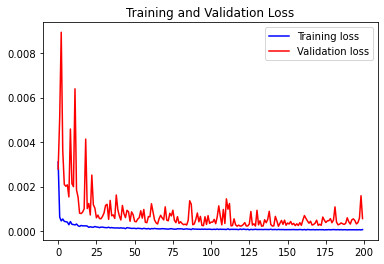

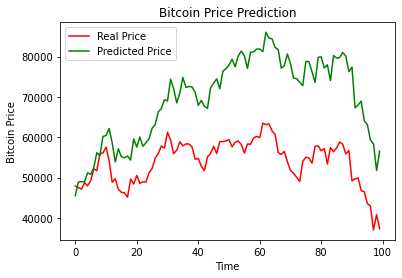

In [116]:
%%time
model_Without_Dropout=Sequential()
model_Without_Dropout.add(LSTM(200,input_shape=(None,1),activation="relu"))
model_Without_Dropout.add(Dense(1))
model_Without_Dropout.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_Without_Dropout = model_Without_Dropout.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_Without_Dropout)
y_pred_Without_Dropout = scaler.inverse_transform(model_Without_Dropout.predict(X_test))
plot_prediction(y_pred_Without_Dropout)
pd.DataFrame(history_Without_Dropout.history).to_csv("model/model_Without_Dropout/history.csv")
model_Without_Dropout.save("model/model_Without_Dropout")

In [39]:
mean_squared_error(y_test, y_pred_Without_Dropout)

92665269.58882584

In [45]:
results_dataframe([("oneLayer_With_Dropout",model_LSTM,337),("oneLayer_Without_Dropout",history_Without_Dropout,336),("multiLayer_With_Dropout",history_Multi_Layer,751),("multiLayer_Without_Dropout",history_Multi_Layer_Without_DropOut,647)])

,model,epochs,dropout,MSE,min_MSE,min_MSE_index,MAE,loss,val_loss,val_MSE,min_val_MSE,min_val_MSE_index,val_MAE,train_time
0,oneLayer_With_Dropout,200,0.2,0.000122,0.000109,159,0.007215,0.000122,0.000246,0.000246,0.000215,198,0.009701,337
1,oneLayer_Without_Dropout,200,0.2,0.000057,0.000052,193,0.004186,0.000057,0.000968,0.000968,0.000205,106,0.015768,336
2,multiLayer_With_Dropout,200,0.2,0.000169,0.000143,196,0.008969,0.000169,0.001016,0.001016,0.000290,131,0.018167,751
3,multiLayer_Without_Dropout,200,0.2,0.000070,0.000068,196,0.005356,0.000070,0.004869,0.004869,0.000287,78,0.041745,647


# 9 CNN-LSTM

Epoch 1/200
16/16 [==============================] - 2s 109ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0508 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0868
Epoch 2/200
16/16 [==============================] - 1s 75ms/step - loss: 6.5305e-04 - mean_squared_error: 6.5305e-04 - mean_absolute_error: 0.0169 - val_loss: 9.9426e-04 - val_mean_squared_error: 9.9426e-04 - val_mean_absolute_error: 0.0186
Epoch 3/200
16/16 [==============================] - 1s 71ms/step - loss: 4.0287e-04 - mean_squared_error: 4.0287e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0229
Epoch 4/200
16/16 [==============================] - 1s 75ms/step - loss: 3.5197e-04 - mean_squared_error: 3.5197e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0250
Epoch 5/200
16/16 [==============================] - 1s 76ms/st

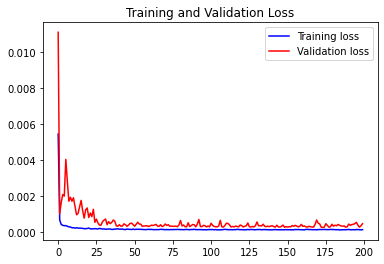

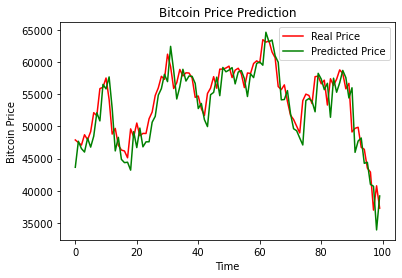

Wall time: 4min 8s


In [39]:
%%time
model_CNN_LSTM_Adam=Sequential()
model_CNN_LSTM_Adam.add(Conv1D(32, (2, ), activation='relu', padding='same',input_shape=(None,1)))
model_CNN_LSTM_Adam.add(Conv1D(64, (2, ), activation='relu', padding='same'))
model_CNN_LSTM_Adam.add(MaxPooling1D((2,)))
model_CNN_LSTM_Adam.add(LSTM(200,activation="relu"))
model_CNN_LSTM_Adam.add(Dropout(0.2)) 
model_CNN_LSTM_Adam.add(Dense(1))
model_CNN_LSTM_Adam.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_CNN_LSTM_Adam = model_CNN_LSTM_Adam.fit(X_train,y_train,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_CNN_LSTM_Adam)
y_pred_CNN_LSTM_Adam = scaler.inverse_transform(model_CNN_LSTM_Adam.predict(X_test))
plot_prediction(y_pred_CNN_LSTM_Adam)
pd.DataFrame(history_CNN_LSTM_Adam.history).to_csv("model/model_CNN_LSTM_Adam/history.csv")
model_CNN_LSTM_Adam.save("model/model_CNN_LSTM_Adam")

In [40]:
mean_squared_error(y_test, y_pred_CNN_LSTM_Adam)

6988844.339776001

Epoch 1/150
16/16 [==============================] - 2s 100ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0381 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0680
Epoch 2/150
16/16 [==============================] - 1s 66ms/step - loss: 7.5565e-04 - mean_squared_error: 7.5565e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0299
Epoch 3/150
16/16 [==============================] - 1s 67ms/step - loss: 6.5493e-04 - mean_squared_error: 6.5493e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0365
Epoch 4/150
16/16 [==============================] - 1s 66ms/step - loss: 6.6429e-04 - mean_squared_error: 6.6429e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0321
Epoch 5/150
16/16 [==============================] - 1s 69ms/step - los

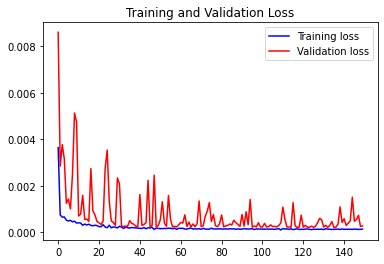

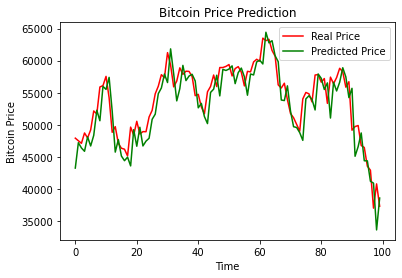

Wall time: 2min 53s


In [48]:
%%time
model_CNN_LSTM_RMS=Sequential()
model_CNN_LSTM_RMS.add(Conv1D(32, (2, ), activation='relu', padding='same',input_shape=(None,1)))
model_CNN_LSTM_RMS.add(Conv1D(64, (2, ), activation='relu', padding='same'))
model_CNN_LSTM_RMS.add(MaxPooling1D((2,)))
model_CNN_LSTM_RMS.add(LSTM(200,activation="relu"))
model_CNN_LSTM_RMS.add(Dropout(0.2)) 
model_CNN_LSTM_RMS.add(Dense(1))
model_CNN_LSTM_RMS.compile(loss="mean_squared_error",optimizer="RMSprop",metrics =[metrics.mse,metrics.mae])
history_CNN_LSTM_RMS = model_CNN_LSTM_RMS.fit(X_train,y_train,epochs=150,batch_size=128,validation_split=0.1)
plot_history(150,history_CNN_LSTM_RMS)
y_pred_CNN_LSTM_RMS = scaler.inverse_transform(model_CNN_LSTM_RMS.predict(X_test))
plot_prediction(y_pred_CNN_LSTM_RMS)
pd.DataFrame(history_CNN_LSTM_RMS.history).to_csv("model/model_CNN_LSTM_RMS/history.csv")
model_CNN_LSTM_RMS.save("model/model_CNN_LSTM_RMS")

In [41]:
mean_squared_error(y_test, y_pred_CNN_LSTM_RMS)

23795608.3215213

In [44]:
results_dataframe([("without_CNN",model_LSTM,337),("LSTM-CNN_Adam",history_CNN_LSTM_Adam,248),("LSTM-CNN_RMS",history_CNN_LSTM_RMS,260)])

,model,epochs,dropout,MSE,min_MSE,min_MSE_index,MAE,loss,val_loss,val_MSE,min_val_MSE,min_val_MSE_index,val_MAE,train_time
0,without_CNN,200,0.2,0.000122,0.000109,159,0.007215,0.000122,0.000246,0.000246,0.000215,198,0.009701,337
1,LSTM-CNN_Adam,200,0.2,0.000112,0.000099,152,0.006711,0.000112,0.000446,0.000446,0.000240,173,0.013905,248
2,LSTM-CNN_RMS,200,0.2,0.000143,0.000111,191,0.008062,0.000143,0.000506,0.000506,0.000199,164,0.014649,260


# 10 Normalization

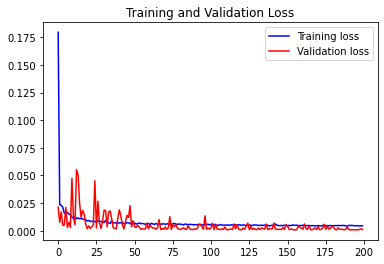

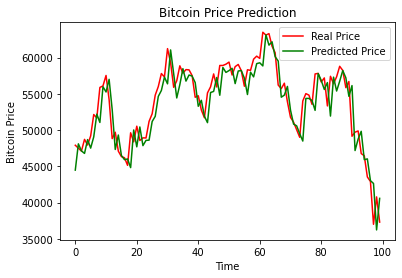

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/model_power\assets
Wall time: 8.32 s


In [6]:
%%time
model_power=Sequential()
model_power.add(LSTM(200,activation="relu",input_shape=(None,1)))
model_power.add(Dropout(0.2)) 
model_power.add(Dense(1))
model_power.compile(loss="mean_squared_error",optimizer="RMSprop",metrics =[metrics.mse,metrics.mae])
history_power = model_power.fit(X_train_power,y_train_power,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_power)
y_pred_power = power_scaler.inverse_transform(model_power.predict(X_test_power))
plot_prediction(y_pred_power)
model_power.save("model/model_power")
pd.DataFrame(history_power.history).to_csv("model/model_power/history.csv")

In [42]:
mean_squared_error(y_test, y_pred_power)

5968199.59566391

Epoch 1/200
16/16 [==============================] - 2s 130ms/step - loss: 0.4563 - mean_squared_error: 0.4563 - mean_absolute_error: 0.5706 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1779
Epoch 2/200
16/16 [==============================] - 1s 89ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1349 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1954
Epoch 3/200
16/16 [==============================] - 1s 87ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0881 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0689
Epoch 4/200
16/16 [==============================] - 2s 95ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0727 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0685
Epoch 5/200
16/16 [==============================] - 1s 88ms/step - loss: 0.0083 - mean_squared

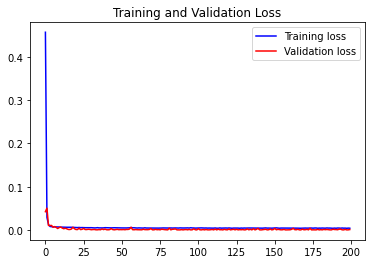

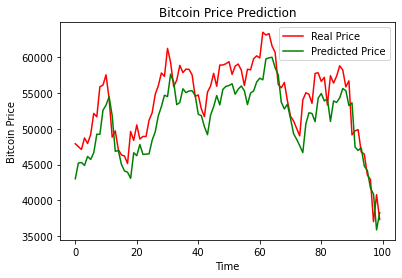

Wall time: 4min 58s


In [ ]:
%%time
model_power_Adam=Sequential()
model_power_Adam.add(LSTM(200,activation="relu",input_shape=(None,1)))
model_power_Adam.add(Dropout(0.2)) 
model_power_Adam.add(Dense(1))
model_power_Adam.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_power_Adam = model_power_Adam.fit(X_train_power,y_train_power,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_power_Adam)
y_pred_power_Adam = power_scaler.inverse_transform(model_power_Adam.predict(X_test_power))
plot_prediction(y_pred_power_Adam)

In [43]:
mean_squared_error(y_test, y_pred_power_Adam)

5630255.459460907

Epoch 1/200
16/16 [==============================] - 2s 150ms/step - loss: 0.1327 - mean_squared_error: 0.1327 - mean_absolute_error: 0.2422 - val_loss: 4.9931 - val_mean_squared_error: 4.9931 - val_mean_absolute_error: 0.6737
Epoch 2/200
16/16 [==============================] - 2s 118ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1087 - val_loss: 0.1212 - val_mean_squared_error: 0.1212 - val_mean_absolute_error: 0.2031
Epoch 3/200
16/16 [==============================] - 2s 117ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1100 - val_loss: 0.1551 - val_mean_squared_error: 0.1551 - val_mean_absolute_error: 0.2930
Epoch 4/200
16/16 [==============================] - 2s 116ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.0977 - val_loss: 0.0512 - val_mean_squared_error: 0.0512 - val_mean_absolute_error: 0.1407
Epoch 5/200
16/16 [==============================] - 2s 117ms/step - loss: 0.0180 - mean_squ

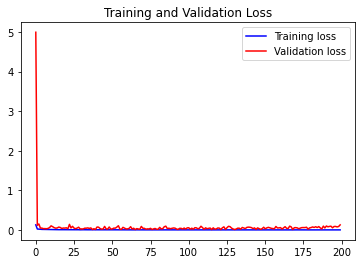

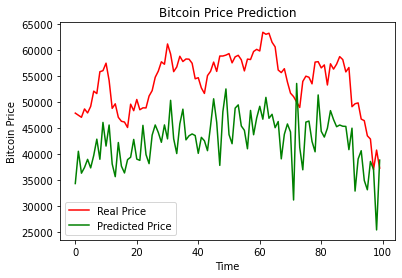

Wall time: 6min 59s


In [54]:
%%time
model_standard=Sequential()
model_standard.add(LSTM(200,activation="relu",input_shape=(None,1)))
model_standard.add(Dropout(0.2)) 
model_standard.add(Dense(1))
model_standard.compile(loss="mean_squared_error",optimizer="RMSprop",metrics =[metrics.mse,metrics.mae])
history_standard = model_standard.fit(X_train_standard,y_train_standard,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_standard)
y_pred_standard = standard_scaler.inverse_transform(model_standard.predict(X_test_standard))
plot_prediction(y_pred_standard)

In [44]:
mean_squared_error(y_test, y_pred_standard)

19364593.852990877

Epoch 1/200
16/16 [==============================] - 3s 178ms/step - loss: 0.2261 - mean_squared_error: 0.2261 - mean_absolute_error: 0.2607 - val_loss: 0.6765 - val_mean_squared_error: 0.6765 - val_mean_absolute_error: 0.7109
Epoch 2/200
16/16 [==============================] - 2s 134ms/step - loss: 0.0524 - mean_squared_error: 0.0524 - mean_absolute_error: 0.1524 - val_loss: 30.5281 - val_mean_squared_error: 30.5281 - val_mean_absolute_error: 1.3681
Epoch 3/200
16/16 [==============================] - 2s 143ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1275 - val_loss: 5.5472 - val_mean_squared_error: 5.5472 - val_mean_absolute_error: 0.8325
Epoch 4/200
16/16 [==============================] - 2s 114ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1131 - val_loss: 1.5159 - val_mean_squared_error: 1.5159 - val_mean_absolute_error: 0.6096
Epoch 5/200
16/16 [==============================] - 2s 113ms/step - loss: 0.0198 - mean_s

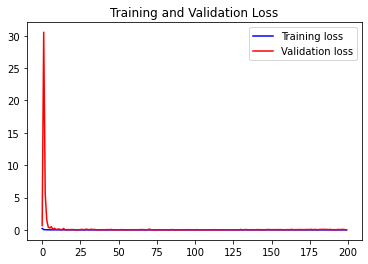

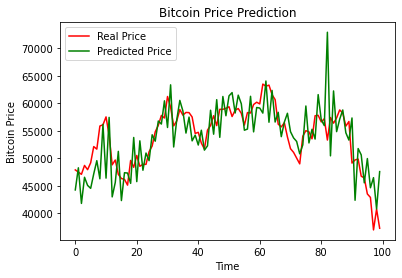

Wall time: 7min 4s


In [55]:
%%time
model_standard_Adam=Sequential()
model_standard_Adam.add(LSTM(200,activation="relu",input_shape=(None,1)))
model_standard_Adam.add(Dropout(0.2)) 
model_standard_Adam.add(Dense(1))
model_standard_Adam.compile(loss="mean_squared_error",optimizer="Adam",metrics =[metrics.mse,metrics.mae])
history_standard_Adam = model_standard_Adam.fit(X_train_standard,y_train_standard,epochs=epochs,batch_size=128,validation_split=0.1)
plot_history(epochs,history_standard_Adam)
y_pred_standard_Adam = standard_scaler.inverse_transform(model_standard_Adam.predict(X_test_standard))
plot_prediction(y_pred_standard_Adam)

In [45]:
mean_squared_error(y_test, y_pred_standard_Adam)

5077166.931455841

In [57]:
results_dataframe([("MinMax-RMS",model_LSTM,337),("Standard-Adam",history_standard_Adam,424),("Standard-RMS",history_standard,420),("Power-Adam",history_power_Adam,299),("Power-RMS",history_power,338)])

,model,epochs,dropout,MSE,min_MSE,min_MSE_index,MAE,loss,val_loss,val_MSE,min_val_MSE,min_val_MSE_index,val_MAE,train_time
0,MinMax-RMS,200,0.2,0.000122,0.000109,159,0.007215,0.000122,0.000246,0.000246,0.000215,198,0.009701,337
1,Standard-Adam,200,0.2,0.005232,0.004744,192,0.046129,0.005232,0.028986,0.028986,0.011008,127,0.089172,424
2,Standard-RMS,200,0.2,0.005285,0.004568,193,0.047002,0.005285,0.131661,0.131661,0.013478,65,0.209829,420
3,Power-Adam,200,0.2,0.004738,0.004567,188,0.052369,0.004738,0.001666,0.001666,0.000819,141,0.030815,299
4,Power-RMS,200,0.2,0.005047,0.004665,177,0.054453,0.005047,0.001875,0.001875,0.000779,122,0.033447,338


# 11 Prediction

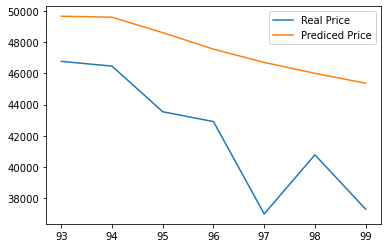

35883695.02508915

In [48]:
priod=7
X_test_11 = X_test[-priod].copy()
for i in range(priod):
    pred = model_LSTM.predict(X_test_11.reshape(1,28,1))
    X_test_11 = np.insert(X_test_11[1:],27,pred)
plt.plot(range(100-priod,100),y_test[-priod:],label="Real Price")
plt.plot(range(100-priod,100),scaler.inverse_transform(X_test_11.reshape(28,1))[-priod:],label="Prediced Price")
plt.legend()
plt.show()
mean_squared_error(y_test[-priod:], scaler.inverse_transform(X_test_11.reshape(28,1))[-priod:])

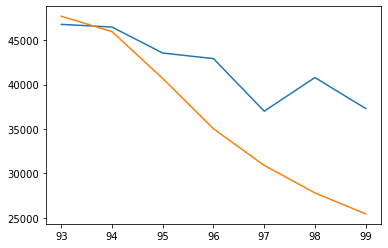

59590831.98053271

In [49]:
priod=7
X_test_11 = X_test[-priod].copy()
for i in range(priod):
    pred = model_CNN_LSTM_RMS.predict(X_test_11.reshape(1,28,1))
    X_test_11 = np.insert(X_test_11[1:],27,pred)
plt.plot(range(100-priod,100),y_test[-priod:],label="Real Price")
plt.plot(range(100-priod,100),scaler.inverse_transform(X_test_11.reshape(28,1))[-priod:],label="Prediced Price")
plt.show()
mean_squared_error(y_test[-priod:], scaler.inverse_transform(X_test_11.reshape(28,1))[-priod:])